In [17]:
import os
import numpy as np
import pandas as pd
import importlib
from tqdm import tqdm
import skimage.io

#supporting functions:
import Colony_Analysis as ca
import Plate_Shuffling as ps
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
## this Notebook extract colony metrics from images of CRI-SPA arrays
##Many Pyphe functions (https://github.com/Bahler-Lab/pyphe) were re-used/tweaked in the analysis

## Plot bar graphs shown in Figure 3A

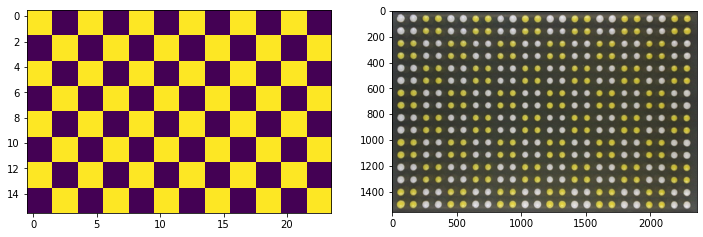

In [9]:
#we have prepared a plate wit interspersed BY_Ref (=ScBTX020) and BY_Btx (=ScBTX021)
#1) we parse the map of the BTX_chess plate
#2) we load the image and reframe it
path = 'Screen_Sample/BTX_chess/'# YUGN24T-Run-1-Plate-001-Ctrl

#load 96wp map
map96 = pd.read_csv(path + '96WP_map.csv', sep =',').iloc[:,1:]
map384 = ps.Combine_Plates(map96,map96,map96,map96)
plate_map = {1: map384}

pic_dict ={}
im=skimage.io.imread(path + 'H48.png')
im=im[750:-790, 870:-900]

fig, axs= plt.subplots(1,2,figsize=(12,10))
axs[0].imshow(map384=='ScBTX021')

axs[1].imshow(im)
plt.show()

Text(0.5, 1.0, 'Filtered')

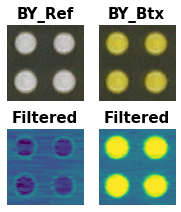

In [11]:
#1) we pass the image through our yellow filter
#2) we map each colony row-column position in the 384 array to a pixel row column position on the image
#3) we select two example quadruplicate patch and display the colony image + filter outpur

#1) we pass the image through our yellow filter
im4grid =  ca.prepare_yellowness_image(im, ca.YPD_yellow)
#2) we map each colony row-column position in the 384 array to a pixel row column position on the image
grid, griddist = ca.make_grid_auto(im4grid, '16-24')
pic_dict['p'+str(1)]= [im,grid]


#3) we select two example quadruplicate patch and display the colony image + filter outpur
frame_opt=80
fig, axs= plt.subplots(2,2,figsize=(3,3.5))
axs = axs.flatten()

##ctrl background:
plates,rows,cols = [0,0,0,0], [8,8,9,9],[12,13,12,13]
Ctrl_im =[]
for i, p in enumerate(plates):
    r=rows[i]
    c= cols[i]
    pic = pic_dict['p'+str(p+1)][0] #10.2.22
    grid = pic_dict['p'+str(p+1)][1]
    colony=ca.colony_picker(pic, r, c, grid,frame_opt )
    Ctrl_im.append(colony)
Ctrl_im = np.vstack((np.hstack((Ctrl_im[0],Ctrl_im[1])),np.hstack((Ctrl_im[2],Ctrl_im[3]))))/255
## WT
plates,rows,cols = [0,0,0,0], [8,8,9,9],[14,15,14,15]

WT_im=[]
for i, p in enumerate(plates):
    r=rows[i]
    c= cols[i]
    pic = pic_dict['p'+str(p+1)][0] #10.2.22
    grid = pic_dict['p'+str(p+1)][1]
    colony=ca.colony_picker(pic, r, c, grid,frame_opt )
    WT_im.append(colony)
WT_im = np.vstack((np.hstack((WT_im[0],WT_im[1])),np.hstack((WT_im[2],WT_im[3]))))/255


axs[0].axis('off')
axs[0].imshow(Ctrl_im,vmin=0, vmax=255)
axs[0].set_title('BY_Ref',size=15,fontweight="bold")
axs[1].axis('off')
axs[1].imshow(WT_im,vmin=0, vmax=255)
axs[1].set_title('BY_Btx',size=15,fontweight="bold")


all_filtered_pxl= np.hstack([ca.HSV_filter(Ctrl_im).flatten(),ca.HSV_filter(Ctrl_im).flatten()])
vmin=all_filtered_pxl.min()
vmax=all_filtered_pxl.max()*1.8
axs[0+2].axis('off')
axs[0+2].imshow(ca.HSV_filter(Ctrl_im),vmin=vmin, vmax=vmax)
axs[0+2].set_title('Filtered',size=15,fontweight="bold")
axs[1+2].axis('off')
axs[1+2].imshow(ca.HSV_filter(WT_im),vmin=vmin, vmax=vmax)
axs[1+2].set_title('Filtered',size=15,fontweight="bold")

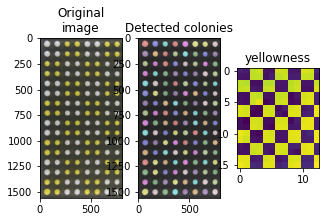

In [27]:
## plot bar graphs of extracted fluorescence
## this cell run the whole image processing workflow for the chess plate

#create the plate,row,col coordinate system
n_row=16
n_col=24
n_plate=1
row = np.arange(0, n_row)
col = np.arange(0, n_col)
col,row = np.meshgrid(col,row)
plate= np.arange(0,n_plate)
row_col = np.vstack((row.flatten(),col.flatten())).T
plate=np.repeat(plate,n_row * n_col).reshape(-1,1)
row_col =np.tile(row_col.T,n_plate).T
coordinate= np.hstack([plate, row_col])


gene_col = map384.reshape(-1,1)

#create the empty data frame storing a reading for each individual position
Data=pd.DataFrame(data=np.hstack((gene_col,coordinate)), columns=['gene','plate', 'row', 'column'])
Data['plate']=Data['plate'].astype('int64')
Data['row']=Data['row'].astype('int64')
Data['column']=Data['column'].astype('int64')
Data


#extract yellowness with HSV map

grid_size='16-24'
plot=1 #plot some quality controls figures
s,t,d, negate = [0.01,1.1,2, 0]

for time in ['48']: #, '48H'
    image_path = 'Screen_Sample/BTX_chess/H'# YUGN24T-Run-1-Plate-001-Ctrl


    #initialize the object storing our data
    Area= np.zeros((16,24,1))
    Mean_intensity = np.zeros((16,24,1))
    #load and frame image
    im=skimage.io.imread(image_path +time+'.png')
    im=im[750:-790, 870:-900]
    #quantify_single_image_HSV does the heavy lifting: 
    #map each colony row-column position in the 384 array to a pixel row column position on the image
    #filters the image through the HSV filter
    #finds the color intensity and size of each colony and map it back to the 384 array coordinate
    plate_data, QC = ca.quantify_single_image_HSV(im,grid_size, True,t,d,s, negate,ca.rgb2gray, ca.HSV_filter  )
    for i in range(len(plate_data)):
        r = int(plate_data.iloc[i,5])
        c = int(plate_data.iloc[i,6])
        Mean_intensity[r-1,c-1,0]  = plate_data.iloc[i,3]
        Area[r-1,c-1,0] = plate_data.iloc[i,1]

    if plot==1: #plot some quality controls figures
        plt.figure(figsize=(5,5))
        plt.subplot(1,3,1)
        plt.title('Original\nimage')
        plt.imshow(im[:,0:800])
        plt.subplot(1,3,2)
        plt.title('Detected colonies')
        plt.imshow(QC[:,0:800,:])
        plt.subplot(1,3,3)
        plt.title('yellowness')
        plt.imshow(Mean_intensity[:,0:13,0] )
        plt.show()

    # we store the area and intensity measurers in our data frame:
    Data['area.'+time] = Area.transpose(2,0,1).flatten()
    Data['mean_intensity.'+time] = Mean_intensity.transpose(2,0,1).flatten()

    






t: 103.5275 p: 5.474319663003714e-11


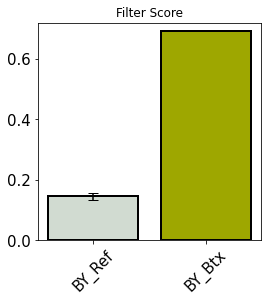

In [28]:
# We now plot the extracted yellonwness intensity

Bottom_color=[209/255,219/255,209/255]
Top_color=[158/255,167/255,0/255]
#we select 4 WT colonies within the center of the plate
metric= 'mean_intensity.48'
DF=Data.copy()


## WT
i_select = (DF.row.isin([8,9])) &(DF.column.isin([14,15]))
WT_score = DF[i_select][metric].mean()
WT_scores = DF[i_select][metric]
WT_std = DF[i_select][metric].std()


##ctrl background:
plates,rows,cols = [0,0,0,0], [8,8,9,9],[12,13,12,13]

i_select = (DF.row.isin([8,9])) &(DF.column.isin([12,13]))
Ctrl_score = DF[i_select][metric].mean()
Ctrl_scores = DF[i_select][metric]
Ctrl_std = DF[i_select][metric].std()


fig, ax = plt.subplots(figsize=(4,4))

colors=[Bottom_color, Top_color]

ax.bar(range(2) ,np.stack([Ctrl_score,WT_score]),yerr=[Ctrl_std,WT_std],edgecolor= 'k',
       linewidth=2,ecolor='k',capsize=5, color= colors)

ax.xaxis.set_ticks(np.arange(2))



ax.set_title('')

ax.tick_params(axis='both', which='major', labelsize=5)
ax.set_xlabel('')
ax.set_xticklabels(['BY_Ref','BY_Btx'],rotation = 45, size=10)
#ax.set_ylim([6000,16000])
ax.tick_params(axis='x',labelsize=15)
ax.tick_params(axis='y',labelsize=15)

ax.set_title('Filter Score')
ax.set_ylim([0.0,0.72])



t, p = stats.ttest_ind(WT_scores, Ctrl_scores)

print('t:',np.round(t,4),'p:',p)


## Plot fluorescence in liquid SC Bargraph 3B)

In [36]:
## load data
data_path ='Liquid_Data/'
Data   = pd.read_csv(data_path +'QD.csv', sep=',')

strain2gene ={

'Sc_BTX20':'No BTX control',
'Sc_BTX21':'BTX WT control',
}

for strain, gene  in strain2gene.items():
    strain2gene[strain] = gene.upper()
gene2strain={}
for strain, gene  in strain2gene.items():
    gene2strain[gene] =strain

t: 5.1411 p: 0.0068
fold diff: 5.984732824427481


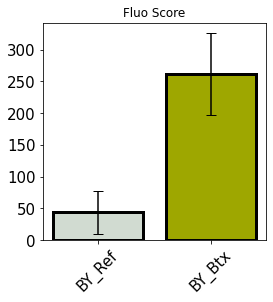

In [38]:
from scipy import stats
DF=Data.copy()


metric =  'SC_Resuspended_Fluo3'

i_select = DF.gene_name== 'BTX WT CONTROL'

WT_score = DF[i_select][metric].mean()
WT_scores = DF[i_select][metric]
WT_std = DF[i_select][metric].std()

i_select = DF.gene_name == 'NO BTX CONTROL'
Ctrl_score = DF[i_select][metric].mean()
Ctrl_scores = DF[i_select][metric]
Ctrl_std = DF[i_select][metric].std()


fig, ax = plt.subplots(figsize=(4,4))

colors=[[209/255,219/255,209/255],[158/255,167/255,0/255]]

ax.bar(range(2) ,np.stack([Ctrl_score,WT_score]),yerr=[Ctrl_std,WT_std],edgecolor= 'k',
       linewidth=3,ecolor='k',capsize=5, color= colors)

ax.xaxis.set_ticks(np.arange(2))



ax.set_title('')

ax.tick_params(axis='both', which='major', labelsize=5)
ax.set_xlabel('')
ax.set_xticklabels(['BY_Ref','BY_Btx'],rotation = 45, size=10)
#ax.set_ylim([6000,16000])
ax.tick_params(axis='x',labelsize=15)
ax.tick_params(axis='y',labelsize=15)

ax.set_title('Fluo Score')




t, p = stats.ttest_ind(WT_scores, Ctrl_scores)

print('t:',np.round(t,4),'p:',np.round(p,4))

print('fold diff:', WT_score/Ctrl_score)


# Extract colony features from 1536 screen plates

#### Generate an empty DF storing all Plate, Row, Column positions within the screen



In [105]:
#generate the random order with which plates were shuffled
order = ps.Shuffle_384to1536(1)
### re-creates the map of randomized genes of the YKO 
shuffled_plate_map = ps.plate_map_maker(order, MapFilePath='Plate_Map.txt')

#create the plate,row,col coordinate system to store the data, we used 1536 (32rows, 48 columns) plates
n_row=32
n_col=48
n_plate=13
row = np.arange(0, n_row)
col = np.arange(0, n_col)
col,row = np.meshgrid(col,row)
plate= np.arange(0,n_plate)
row_col = np.vstack((row.flatten(),col.flatten())).T
plate=np.repeat(plate,n_row * n_col).reshape(-1,1)
row_col =np.tile(row_col.T,n_plate).T
coordinate= np.hstack([plate, row_col])
#create the gene name column (!! need to use the right plate map)
gene_col=[] #stores the gene ID
for p in range(n_plate):
    gene_col.append(shuffled_plate_map[p+1].flatten())
gene_col = np.hstack(gene_col).reshape(-1,1)

#create the data frame storing a read-out for each individual position
Data=pd.DataFrame(data=np.hstack((gene_col,coordinate)), columns=['gene','plate', 'row', 'column'])
Data['plate']=Data['plate'].astype('int64')
Data['row']=Data['row'].astype('int64')
Data['column']=Data['column'].astype('int64')


#### Extract Metrics from Raw images and fills our Data Frame:

In [80]:
#we first retrieve the plates name (files always finish with '-Ctrl.png')
image_path = 'Screen_Sample/Screen1_9.9.21/'# YUGN24T-Run-1-Plate-001-Ctrl
plate_path_dict={}

#this follows image_path to read the plate name 
for filename in os.listdir(image_path):
    if '-Ctrl.png' in filename:
        i = filename.index('-Ctrl.png') -3
        plate_num = int(filename[i:i+3])
        plate_path_dict[plate_num] = image_path+ '/' + filename

In [82]:
#extract colony size and yellowness with HSV map

plot=0 #option to plot figures when running extraction:


# set some Pyphe paramters
#s,t,d,i >>size_threshold parameter/ image back_ground threshold parameter/ d?/invert image
#background thresh the lower the more the background is sensed as colony
s,t,d, negate = [0.3,1,2, 0]
grid_size='32-48' #screen is in 1536 format
QC=dict() #dict will store Quality control images



#initialize the object storing our data
Area= np.zeros((32,48,13))
Mean_intensity = np.zeros((32,48,13))

#loop extracting the data: Lets GO!
for p, plate in plate_path_dict.items():
    print(plate +'... processed')
    im=skimage.io.imread(plate)
    #we crop the pictures
    im=im[460:1432,530:1990]
    plate_data, QC[p] = ca.quantify_single_image_HSV(im,grid_size, True,t,d,s, negate,ca.rgb2gray, ca.HSV_filter  )
    # we reformat the data to match our plate format
    for i in range(len(plate_data)):
        r = int(plate_data.iloc[i,5])
        c = int(plate_data.iloc[i,6])
        Mean_intensity[r-1,c-1,p-1]  = plate_data.iloc[i,3]
        Area[r-1,c-1,p-1] = plate_data.iloc[i,1]

    if plot:
        plt.figure(figsize=(15,15))
        plt.subplot(1,3,1)
        plt.imshow(im[:,0:400])
        plt.subplot(1,3,2)
        plt.imshow(QC[p][:,0:400,:])
        plt.subplot(1,3,3)
        plt.imshow(Mean_intensity[:,0:13,p-1] )
        plt.show()

## we transfer the data to our final data frame
Data['area.24'] = Area.transpose(2,0,1).flatten()
Data['mean_intensity.24'] = Mean_intensity.transpose(2,0,1).flatten()

## Save unprocessed data:

#Data.to_csv('your_path/Raw_Data.csv', sep=',')


Screen_Sample/Screen1_9.9.21//YUGN24_T-006-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-007-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-011-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-010-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-001-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-012-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-013-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-005-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-004-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-009-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//NewProject-YUGN24T-Run-1-Plate-008-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-002-Ctrl.png... processed
Screen_Sample/Screen1_9.9.21//YUGN24_T-003-Ctrl.png... processed


### We now process data in several steps:

In [7]:
## 1) correct edge effects
## 2) Turns 0 to nan and standardise the data
## 3) Filter outlier colonies (Grubbs' test) 


In [83]:
#correct for edge effects, only the column in metrics are corrected
metrics=[c for c in Data.columns if 'intensity' in c or 'area' in c]
#correct for edge effect:
Data_corrected = ca.correct_edges(Data,  metrics, default_cols=['gene','plate','row','column'],n_edges =5)



### Plot actual and corrected Data

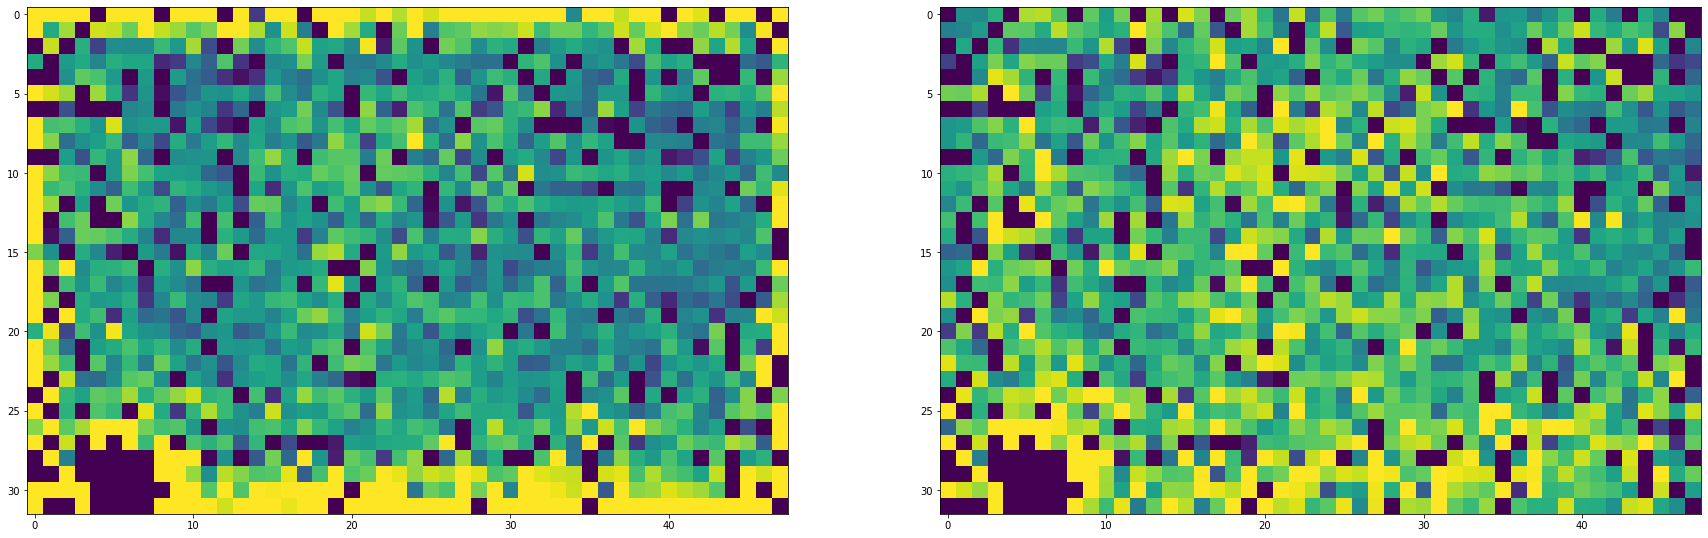

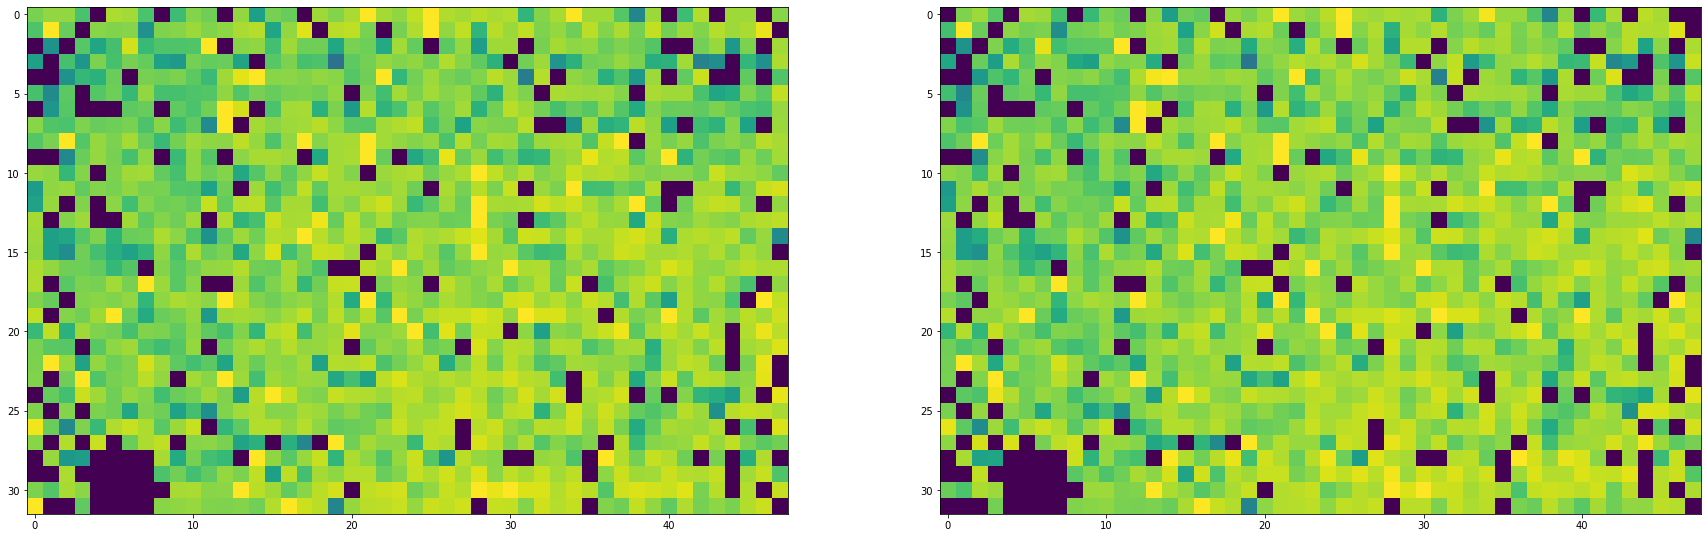

In [84]:
#check:
p=1
metric='area'
DF = Data_corrected.copy()
before= DF.loc[DF['plate']== p, metric]
after= DF.loc[DF['plate']== p,'corrected_' + metric]
plt.figure(figsize=[30,30])
plt.subplot(1,2,1)

plt.imshow(before.values.reshape((32,48)), vmin=before.mean()-before.std(), vmax=before.mean()+before.std())
plt.subplot(1,2,2)
plt.imshow(after.values.reshape((32,48)), vmin=after.mean()-after.std(), vmax=after.mean()+after.std())
plt.show()


metric='mean_intensity'
before= DF.loc[DF['plate']== p, metric]
after= DF.loc[DF['plate']== p,'corrected_' + metric]
plt.figure(figsize=[30,30])
plt.subplot(1,2,1)
plt.imshow(before.values.reshape((32,48)), vmin=0, vmax= before.mean()+before.std())
plt.subplot(1,2,2)
plt.imshow(after.values.reshape((32,48)), vmin=0,vmax=before.mean()+before.std())
plt.show()


In [85]:
# We are going to standardise the data
#Pyphe returns a 0 read-out for empty position. we need to convert this 0 to nans
#turn 0 into NaNs
metrics = [m for m in Data_corrected.columns if 'area' in m or 'intensity'  in m   ]
Data_corrected[metrics] = Data_corrected[metrics].replace(0, np.nan)


In [86]:

metrics = [m for m in Data_corrected.columns if 'area' in m or 'intensity'  in m   ]

##normalise data
for col in Data_corrected:
    if 'corrected' in col:
        Data_corrected[col]= (Data_corrected[col]-Data_corrected[col].mean())/Data_corrected[col].std()
        


In [87]:
## this cell removes (i.e. set their readouts to NaN) outliers and genes with less than 3 replicates

#1) Removes genes with less than 3 replicates
#2) Compute Z score for individual replicates
#3) Remove replicate outliers if Z > threshold
#4) Removes genes with less than 3 replicates after outliers removal

#Filter data for individual and combined data
metrics=[c for c in Data_corrected.columns if 'area' in c or 'intensity' in c]
#1)
Data_corrected = ca.Filter_3(Data_corrected, metrics)
#2)
Data_corrected = ca.Compute_Zscore(Data_corrected,metrics)
#3)
Data_corrected = ca.Filter_Z(Data_corrected, metrics)
#4)
Data_corrected = ca.Filter_3(Data_corrected,  metrics)

100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


In [88]:
# here we compute the mean, std, and count for each gene
#the replicate number for each metric
metrics=[c for c in Data_corrected.columns if 'area' in c or 'intensity' in c]
Plate_Data = ca.group_by_gene(Data_corrected, metrics)

In [107]:
dont run
#save data
Plate_Data.to_csv('GA1.csv', sep=',')
Data_corrected.to_csv('QD1.csv', sep=',')



### Visualize Screen Result

In [110]:
##Load data
Plate_Data = pd.read_csv('GA1.csv')

In [57]:
(Plate_Data['area.24_count']>3).sum()/len(Plate_Data)

0.6862990810359232

top middle difference 3.397807564086679e-08
middle down difference 3.397807564086679e-08


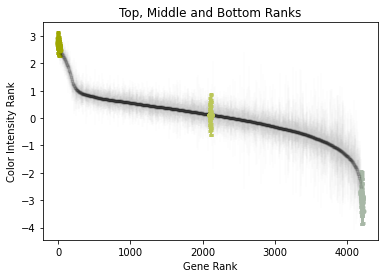

In [111]:
#Produce Screen Rank

from scipy.stats import mannwhitneyu
metric = 'corrected_mean_intensity.24'


i_nan = Plate_Data[metric+'_mean'].isna() ==0

i_sort =  Plate_Data[i_nan][metric+'_mean'].argsort()[::-1]
i_middle_group =  np.arange(len( Plate_Data[i_nan])/2-10,len( Plate_Data[i_nan])/2+10)
i_top_group =  np.arange(0,20)
i_bottom_group =  np.arange(-20,0)

i_all= np.arange(i_nan.sum())
All= Plate_Data[i_nan].iloc[i_sort][metric+'_mean']
All_err= Plate_Data[i_nan].iloc[i_sort][metric+'_std']

Top = Plate_Data[i_nan].iloc[i_sort].iloc[i_top_group][metric+'_mean']
Top_err = Plate_Data[i_nan].iloc[i_sort].iloc[i_top_group][metric+'_std']
Top_genes = Plate_Data[i_nan].iloc[i_sort].iloc[i_top_group]['gene'].values
Middle =  Plate_Data[i_nan].iloc[i_sort].iloc[i_middle_group][metric+'_mean']
Middle_err = Plate_Data[i_nan].iloc[i_sort].iloc[i_middle_group][metric+'_std']
Middle_genes =  Plate_Data[i_nan].iloc[i_sort].iloc[i_middle_group]['gene'].values
                                                                    
Bottom = Plate_Data[i_nan].iloc[i_sort].iloc[i_bottom_group][metric+'_mean']
Bottom_err = Plate_Data[i_nan].iloc[i_sort].iloc[i_bottom_group][metric+'_std']
Bottom_genes = Plate_Data[i_nan].iloc[i_sort].iloc[i_bottom_group]['gene'].values

Bottom_color=[168/255,184/255,167/255]
Middle_color=[187/255,199/255,90/255]
Top_color=[158/255,167/255,0]

i = np.arange(0,len(i_all), 1)
#plt.errorbar(i_all[i], All.iloc[i], All_err.iloc[i], linestyle='', marker = '.', color='k', alpha=0.1)
plt.errorbar(i_all[i], All.iloc[i], All_err.iloc[i], linestyle='', marker = '.', color='k', alpha=0.01)

plt.errorbar(i_middle_group, Middle, Middle_err, c=Middle_color , marker = '.',  capsize=2, elinewidth=2, markeredgewidth=3)

plt.errorbar(i_top_group,Top, Top_err, c=Top_color, marker = '.',  capsize=2, elinewidth=2, markeredgewidth=3 )

plt.errorbar(i_bottom_group+len(i_all),Bottom, Bottom_err, c=Bottom_color, marker = '.',  capsize=2, elinewidth=2, markeredgewidth=3 )
plt.title('Top, Middle and Bottom Ranks')
plt.xlabel('Gene Rank')
plt.ylabel('Color Intensity Rank')
U1, p = mannwhitneyu( Top, Middle)
print('top middle difference',p)
U1, p = mannwhitneyu(Middle, Bottom)
print('middle down difference',p)


### Display Colony Pictures From Plates:

In [101]:
%%time
#to avoid reopenning images and find their grids for each colony we store the images and the grids in a dict:

pic_dict={} #dictionary storing images and colony positions (grid)
    
for p, plate in plate_path_dict.items(): 
    print(p,plate)
    im=skimage.io.imread(plate)
    im=im[460:1432,530:1990]
    im4grid =  ca.prepare_yellowness_image(im, ca.YPD_yellow)
    grid, griddist = ca.make_grid_auto(im4grid, '32-48')
    pic_dict['p'+ str(p)]=[im,grid]
            
            

6 Screen_Sample/Screen1_9.9.21//YUGN24_T-006-Ctrl.png
7 Screen_Sample/Screen1_9.9.21//YUGN24_T-007-Ctrl.png
11 Screen_Sample/Screen1_9.9.21//YUGN24_T-011-Ctrl.png
10 Screen_Sample/Screen1_9.9.21//YUGN24_T-010-Ctrl.png
1 Screen_Sample/Screen1_9.9.21//YUGN24_T-001-Ctrl.png
12 Screen_Sample/Screen1_9.9.21//YUGN24_T-012-Ctrl.png
13 Screen_Sample/Screen1_9.9.21//YUGN24_T-013-Ctrl.png
5 Screen_Sample/Screen1_9.9.21//YUGN24_T-005-Ctrl.png
4 Screen_Sample/Screen1_9.9.21//YUGN24_T-004-Ctrl.png
9 Screen_Sample/Screen1_9.9.21//YUGN24_T-009-Ctrl.png
8 Screen_Sample/Screen1_9.9.21//NewProject-YUGN24T-Run-1-Plate-008-Ctrl.png
2 Screen_Sample/Screen1_9.9.21//YUGN24_T-002-Ctrl.png
3 Screen_Sample/Screen1_9.9.21//YUGN24_T-003-Ctrl.png
CPU times: user 27.6 s, sys: 780 ms, total: 28.4 s
Wall time: 29.1 s


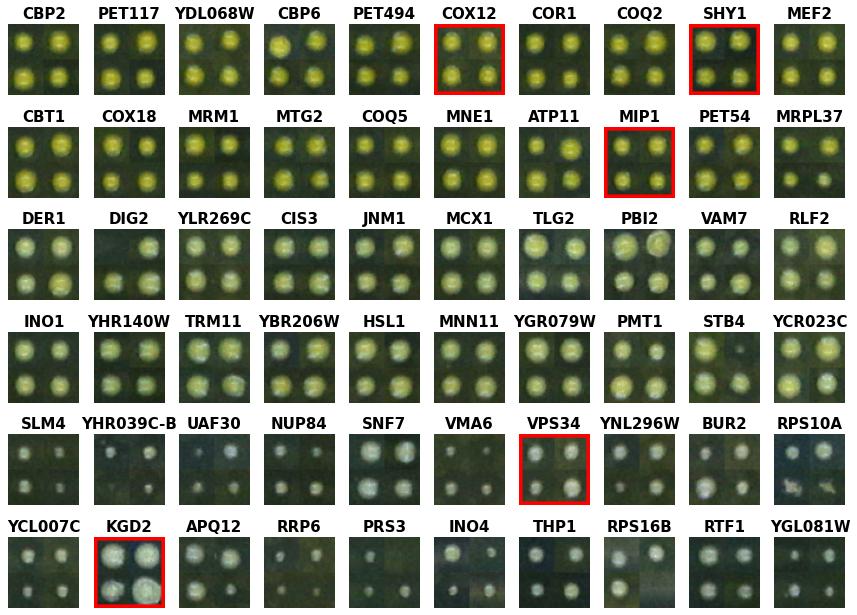

In [106]:
## this loop might look complex, 
## it is because we need to retrieve the positions of the 4 randomized replicates for the genes we want to plot:
fig, axs= plt.subplots(6,10, figsize=(15,11))
axs= axs.flatten()
frame_opt = 30 #number of pixels framing the center of the colony
for i_plot, gene in enumerate(np.hstack([Top_genes,Middle_genes,Bottom_genes])):

    #find coordinate of colonies in shuffled plate
    plates,rows,cols = ca.gene_loc_finder(gene , shuffled_plate_map)

    # go and find the picture of the colony on the plate
    replicates=[]
    for i, p in enumerate(plates):
        r=rows[i]
        c= cols[i]
        pic = pic_dict['p'+str(p+1)][0] #10.2.22
        grid = pic_dict['p'+str(p+1)][1]
        colony=ca.colony_picker(pic, r, c, grid,frame_opt ).astype(np.uint8)
    
        replicates.append(colony)

    #stack colony pictures:
    replicates = np.vstack((np.hstack((replicates[0],replicates[1])),np.hstack((replicates[2],replicates[3]))))
    #underline edge colonies with red
    #frame the genes selected for comfirmation in red
    if gene in ['VPS34','KGD2', 'CAX4', 'CUR1', 'NAM7', 'YKU70','COX12', 'SHY1', 'MIP1']:
        replicates[-3:,:,:]=[255,0,0]
        replicates[0:3,:,:]=[255,0,0]
        replicates[:,0:3,:]=[255,0,0]
        replicates[:,-3:,:]=[255,0,0]

    axs[i_plot].axis('off')
    axs[i_plot].imshow(replicates,vmin=0, vmax=1)
    axs[i_plot].set_title(gene, size=15,fontweight="bold")
plt.show()